<a href="https://colab.research.google.com/github/Plabanzeoanai/NLP/blob/main/Huggingface_Sentence_transformer__classify_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks.

In [1]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 12.8 MB/s 
     |████████████████████████████████| 636 kB 54.8 MB/s 
     |████████████████████████████████| 895 kB 69.2 MB/s 
     |████████████████████████████████| 3.3 MB 54.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## sentence-transformers/bert-base-nli-mean-tokens
This is a sentence-transformers model: It maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search.

In [2]:
!pip install -U sentence-transformers

     |████████████████████████████████| 85 kB 4.2 MB/s 
     |████████████████████████████████| 1.2 MB 19.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-py3-none-any.whl size=126709 sha256=0502b1a704d244460487e7186d020b1a1df16bd828738316ea6f7a0701827d38
  Stored in directory: /root/.cache/pip/wheels/d1/c1/0f/faafd427f705c4b012274ba60d9a91d75830306811e1355293
Successfully built sentence-transformers


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Sentence Transformers -Distilbert

In [64]:
import pandas as pd
import numpy as np
from sklearn.metrics import  (auc,confusion_matrix,roc_auc_score,roc_curve,f1_score,accuracy_score,classification_report)
from sklearn.model_selection import *
from yellowbrick.classifier import (ConfusionMatrix,ROCAUC,)
from yellowbrick.model_selection import (LearningCurve,)

import warnings
warnings.filterwarnings('ignore')

## Read Training Data

In [5]:
!wget "https://cogcomp.seas.upenn.edu/Data/QA/QC/train_5500.label"  -O newfile.txt

--2021-07-25 15:19:54--  https://cogcomp.seas.upenn.edu/Data/QA/QC/train_5500.label
Resolving cogcomp.seas.upenn.edu (cogcomp.seas.upenn.edu)... 158.130.57.77
Connecting to cogcomp.seas.upenn.edu (cogcomp.seas.upenn.edu)|158.130.57.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335858 (328K)
Saving to: ‘newfile.txt’

newfile.txt         100%[===================>] 327.99K  1021KB/s    in 0.3s    

2021-07-25 15:19:55 (1021 KB/s) - ‘newfile.txt’ saved [335858/335858]



## Seggregate Label and Text

In [6]:
label = []
question = []
with open("/content/newfile.txt","r",encoding="ISO-8859-1") as f:
  for line in f.readlines():
    text = line.split(":")
    label.append(text[0])
    question.append(text[1])

## Get the data into DataFrame

In [13]:
train = pd.DataFrame({'Question':question,'Label':label})

In [14]:
train.head()

,Question,Label
0,manner How did serfdom develop in and then lea...,DESC
1,cremat What films featured the character Popey...,ENTY
2,manner How can I find a list of celebrities ' ...,DESC
3,animal What fowl grabs the spotlight after the...,ENTY
4,exp What is the full form of .com ?\n,ABBR


## Data Decription

In [15]:
train.shape

(5452, 2)

## Label Distribution

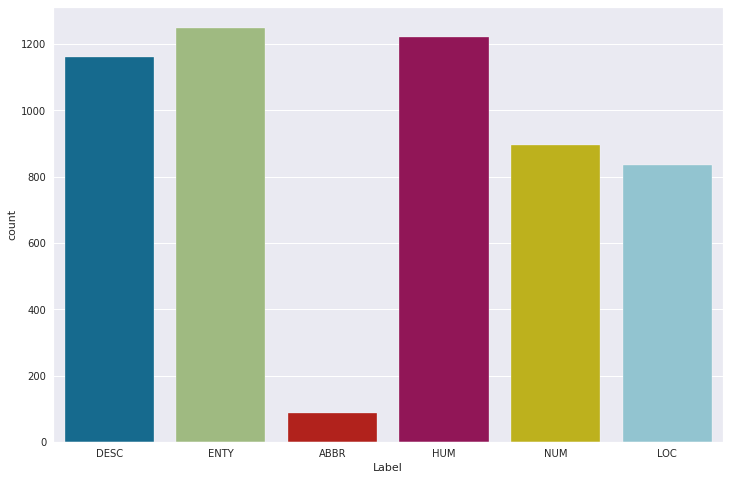

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
sns.countplot(train['Label'])
plt.show()

## Define a function to map the labels DESC or FACT

In [17]:
def map_labels(x):
  if x == "DESC":
    return "DESC"
  else:
    return "FACT"

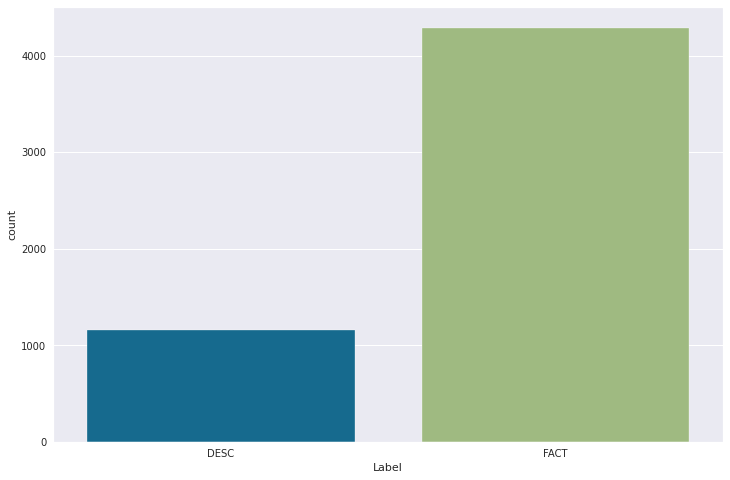

In [18]:
train['Label'] = train['Label'].map(map_labels)
plt.figure(figsize=(12,8))
sns.countplot(train['Label'])
plt.show()

## Reading the excel file supplied as additional training data

In [19]:
df_add = pd.read_excel("/content/drive/MyDrive/ZeonAI/Trainingset_queryclassifier.xlsx",sheet_name='Trainset')

In [20]:
df_add.head()

,Question,Class
0,Who is CEO designate at HDFC ?,Fact
1,What was the year on year loan growth in HDFC ...,Fact
2,What percentage of HDFC's distribution network...,Fact
3,What is the opinion of HighCourt in Santosh To...,Desc
4,"In Santosh Toppo vs state of odisha case, what...",Desc


In [22]:
df_add = df_add.rename(columns={'Class':'Label'})
df_add.Label.value_counts(normalize=True)

Fact    0.594937
Desc    0.405063
Name: Label, dtype: float64

In [23]:
train.head()

,Question,Label
0,manner How did serfdom develop in and then lea...,DESC
1,cremat What films featured the character Popey...,FACT
2,manner How can I find a list of celebrities ' ...,DESC
3,animal What fowl grabs the spotlight after the...,FACT
4,exp What is the full form of .com ?\n,FACT


In [25]:
train.shape

(5452, 2)

In [24]:
df_add.head()

,Question,Label
0,Who is CEO designate at HDFC ?,Fact
1,What was the year on year loan growth in HDFC ...,Fact
2,What percentage of HDFC's distribution network...,Fact
3,What is the opinion of HighCourt in Santosh To...,Desc
4,"In Santosh Toppo vs state of odisha case, what...",Desc


In [26]:
df_add.shape

(79, 2)

In [27]:
train = pd.concat([train,df_add],axis=0)
train.shape

(5531, 2)

In [30]:
train.Label.value_counts(normalize=True)

FACT    0.789911
DESC    0.210089
Name: Label, dtype: float64

In [31]:
train.shape

(5531, 2)

## Final Training Data Label distribution

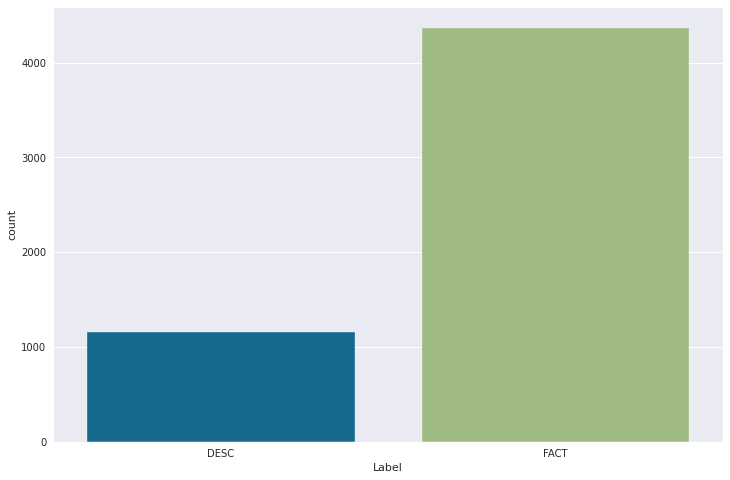

In [29]:
plt.figure(figsize=(12,8))
sns.countplot(train['Label'])
plt.show()

## Using Transformer Pipeline

In [32]:
sentences = train['Question'].values.tolist()

In [33]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/distilbert-base-nli-mean-tokens')
embeddings = model.encode(sentences)
print(embeddings)


[[-1.2805133  -0.47905654 -0.07459314 ... -0.6903942   0.65552545
   0.4299319 ]
 [ 0.05076513 -0.2315879   0.44918117 ... -0.9458774   0.582182
   0.16936457]
 [ 0.16578268  0.08628527  0.99605757 ... -1.4010975  -0.16692434
  -0.66698927]
 ...
 [-0.36153388  0.15054157  0.15476921 ... -0.08347503  0.5446452
  -0.7916234 ]
 [-0.55576617 -0.5143806  -0.07920627 ...  0.4858238   0.52702147
  -1.3873914 ]
 [-0.6264321  -0.40990892 -0.3430348  ...  0.24374509  0.09738968
  -0.99024826]]


* The data we pass between the two models is a vector of size 768. We can think of this of vector as an embedding for the sentence that we can use for classification.

In [34]:
train_vector = pd.DataFrame(np.array(embeddings))

In [35]:
train_vector.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-1.280513,-0.479057,-0.074593,-1.078833,0.555027,-0.304827,0.710984,0.278825,0.129274,0.484494,0.194379,0.099252,0.048627,0.641369,0.453775,-0.550658,-0.685677,0.614255,-0.001949,-0.382198,-0.034111,0.072872,0.070514,-0.182452,-0.672063,-0.203226,0.207312,-0.494412,-0.015926,0.394312,0.036818,0.289581,0.572028,0.346302,-0.048940,0.285914,0.699641,0.078200,-0.658135,-0.720307,...,-0.032482,-1.037481,-0.430439,0.345353,-0.443688,0.326153,0.006781,-0.017736,0.361109,0.084457,-0.220593,-0.326400,0.109498,-0.313511,0.126476,-1.023944,0.019120,0.276655,0.090974,-0.871337,0.066085,0.055102,0.710252,0.815904,0.116723,-0.763052,-0.191135,-0.117060,-0.917495,0.238745,-0.721925,-0.708831,0.919504,0.014720,-0.218466,-0.707999,-0.060461,-0.690394,0.655525,0.429932
1,0.050765,-0.231588,0.449181,-0.434117,-0.437005,-0.025377,0.901859,0.299691,0.397571,0.363239,0.813872,-0.242552,-0.046876,0.664556,0.063659,-0.778084,-0.464536,0.818348,0.217839,-0.682176,-0.048324,0.305596,0.005277,-0.105053,-0.850086,-0.180318,0.599913,-0.693822,-0.018520,0.129673,0.459312,0.366443,-0.351863,0.442381,0.333915,-0.367255,1.370850,-0.371237,-0.394274,0.127977,...,-0.759870,-0.319705,-0.320549,0.269263,-0.234702,0.203369,0.363199,0.800868,0.343576,0.986706,-0.211597,0.346223,-0.544377,0.259784,-0.261309,-0.354508,-0.033133,0.439806,0.176840,-0.155799,-1.046834,-0.140347,0.822187,1.090696,-0.127105,-1.281975,0.121476,-0.035386,-1.036541,-0.455563,-1.028530,-0.167689,-0.617334,-0.128336,-0.154140,0.052781,0.287511,-0.945877,0.582182,0.169365
2,0.165783,0.086285,0.996058,-0.007494,-0.062556,-0.447119,1.157736,-0.594608,-0.278916,0.288759,-0.755688,0.518913,-0.589019,-0.218035,-0.299750,-0.588890,-1.044726,0.417887,-0.516429,-0.688118,0.293211,0.023602,-0.186256,0.847153,-0.451656,0.414896,0.153552,-0.524880,0.480987,0.345678,0.525045,0.589051,-0.483123,0.143385,0.049669,-0.625910,1.300623,-0.494312,0.039376,-0.539756,...,-0.288382,0.158903,-0.675779,-0.603539,-0.569769,0.099041,0.707025,0.829515,-0.109335,0.677547,0.197822,0.223959,-0.297395,-0.826129,-0.965579,-0.218842,1.487624,-0.247484,-0.609410,-0.065343,-0.464756,-0.134924,1.308986,0.461914,-0.319942,-0.315665,-0.672880,0.423251,-1.299873,-0.380741,-1.354729,-0.239815,-0.171939,0.529478,-0.135893,1.097948,-0.018599,-1.401098,-0.166924,-0.666989
3,-0.178117,-0.473958,0.048357,-1.291486,-0.028839,0.348843,-0.046127,0.052366,-0.436607,1.082325,1.379477,0.269813,-0.224945,0.555075,0.196508,-1.012059,-0.139680,0.013313,0.595400,-0.556999,-0.128182,0.313684,-0.397969,0.625162,-1.139045,0.605109,0.438818,-0.294600,-0.015437,-0.200387,-0.028176,0.543886,-0.501193,0.160217,-0.207827,-0.185351,0.511596,-0.588324,0.523013,-0.696837,...,-1.323598,-0.134632,-0.420599,-0.185516,-0.183404,0.793519,0.255795,0.518475,0.655392,0.389528,-0.159402,0.155687,-0.318773,-0.182897,-0.584351,-1.437036,0.627801,0.532542,0.662939,0.678889,-0.622288,0.319153,0.996853,0.696457,0.012059,-0.387256,0.541324,0.047869,-0.789448,-0.599024,-0.941753,0.158490,-0.710274,0.030269,0.281970,0.180029,0.274251,-0.035899,1.007164,-0.209412
4,-0.341517,-0.614352,0.075421,-0.381870,-0.037142,-0.639595,1.047396,1.109776,-0.500967,-0.308551,-0.026306,0.817467,0.180813,0.402919,0.446856,-0.506134,-0.852798,0.875699,-0.568851,-0.948410,0.342488,-0.257153,-0.041044,1.054365,0.182189,0.183330,0.685496,-0.191475,-0.196328,-0.376523,0.161194,-0.232624,-0.124186,0.408084,0.532743,-0.697111,-0.076796,-0.269128,-0.596582,-0.246367,...,-0.935546,0.314507,-0.171532,-0.507654,-0.372031,0.384393,-0.427786,-0.062957,0.381884,-0.210031,-0.373228,0.138790,-0.295719,-0.431427,-0.521124,0.406644,0.222613,-0.539807,-0.619525,0.157020,-0.941711,-0.363686,0.716169,-0.360151,-0.008979,-0.696636,-0.872139,0.

In [40]:
train_vector.shape

(5531, 768)

In [41]:
train.shape

(5531, 2)

## Concat genereated word Vector aloing with the original text and label

In [45]:
train_vector['Question'] = train['Question'].values.tolist()

In [46]:
train_vector['Label'] = train['Label'].values.tolist()

In [47]:
train_vector.shape

(5531, 770)

In [49]:
final_train = train_vector.copy()

In [50]:
final_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,Question,Label
0,-1.280513,-0.479057,-0.074593,-1.078833,0.555027,-0.304827,0.710984,0.278825,0.129274,0.484494,0.194379,0.099252,0.048627,0.641369,0.453775,-0.550658,-0.685677,0.614255,-0.001949,-0.382198,-0.034111,0.072872,0.070514,-0.182452,-0.672063,-0.203226,0.207312,-0.494412,-0.015926,0.394312,0.036818,0.289581,0.572028,0.346302,-0.048940,0.285914,0.699641,0.078200,-0.658135,-0.720307,...,-0.430439,0.345353,-0.443688,0.326153,0.006781,-0.017736,0.361109,0.084457,-0.220593,-0.326400,0.109498,-0.313511,0.126476,-1.023944,0.019120,0.276655,0.090974,-0.871337,0.066085,0.055102,0.710252,0.815904,0.116723,-0.763052,-0.191135,-0.117060,-0.917495,0.238745,-0.721925,-0.708831,0.919504,0.014720,-0.218466,-0.707999,-0.060461,-0.690394,0.655525,0.429932,manner How did serfdom develop in and then lea...,DESC
1,0.050765,-0.231588,0.449181,-0.434117,-0.437005,-0.025377,0.901859,0.299691,0.397571,0.363239,0.813872,-0.242552,-0.046876,0.664556,0.063659,-0.778084,-0.464536,0.818348,0.217839,-0.682176,-0.048324,0.305596,0.005277,-0.105053,-0.850086,-0.180318,0.599913,-0.693822,-0.018520,0.129673,0.459312,0.366443,-0.351863,0.442381,0.333915,-0.367255,1.370850,-0.371237,-0.394274,0.127977,...,-0.320549,0.269263,-0.234702,0.203369,0.363199,0.800868,0.343576,0.986706,-0.211597,0.346223,-0.544377,0.259784,-0.261309,-0.354508,-0.033133,0.439806,0.176840,-0.155799,-1.046834,-0.140347,0.822187,1.090696,-0.127105,-1.281975,0.121476,-0.035386,-1.036541,-0.455563,-1.028530,-0.167689,-0.617334,-0.128336,-0.154140,0.052781,0.287511,-0.945877,0.582182,0.169365,cremat What films featured the character Popey...,FACT
2,0.165783,0.086285,0.996058,-0.007494,-0.062556,-0.447119,1.157736,-0.594608,-0.278916,0.288759,-0.755688,0.518913,-0.589019,-0.218035,-0.299750,-0.588890,-1.044726,0.417887,-0.516429,-0.688118,0.293211,0.023602,-0.186256,0.847153,-0.451656,0.414896,0.153552,-0.524880,0.480987,0.345678,0.525045,0.589051,-0.483123,0.143385,0.049669,-0.625910,1.300623,-0.494312,0.039376,-0.539756,...,-0.675779,-0.603539,-0.569769,0.099041,0.707025,0.829515,-0.109335,0.677547,0.197822,0.223959,-0.297395,-0.826129,-0.965579,-0.218842,1.487624,-0.247484,-0.609410,-0.065343,-0.464756,-0.134924,1.308986,0.461914,-0.319942,-0.315665,-0.672880,0.423251,-1.299873,-0.380741,-1.354729,-0.239815,-0.171939,0.529478,-0.135893,1.097948,-0.018599,-1.401098,-0.166924,-0.666989,manner How can I find a list of celebrities ' ...,DESC
3,-0.178117,-0.473958,0.048357,-1.291486,-0.028839,0.348843,-0.046127,0.052366,-0.436607,1.082325,1.379477,0.269813,-0.224945,0.555075,0.196508,-1.012059,-0.139680,0.013313,0.595400,-0.556999,-0.128182,0.313684,-0.397969,0.625162,-1.139045,0.605109,0.438818,-0.294600,-0.015437,-0.200387,-0.028176,0.543886,-0.501193,0.160217,-0.207827,-0.185351,0.511596,-0.588324,0.523013,-0.696837,...,-0.420599,-0.185516,-0.183404,0.793519,0.255795,0.518475,0.655392,0.389528,-0.159402,0.155687,-0.318773,-0.182897,-0.584351,-1.437036,0.627801,0.532542,0.662939,0.678889,-0.622288,0.319153,0.996853,0.696457,0.012059,-0.387256,0.541324,0.047869,-0.789448,-0.599024,-0.941753,0.158490,-0.710274,0.030269,0.281970,0.180029,0.274251,-0.035899,1.007164,-0.209412,animal What fowl grabs the spotlight after the...,FACT
4,-0.341517,-0.614352,0.075421,-0.381870,-0.037142,-0.639595,1.047396,1.109776,-0.500967,-0.308551,-0.026306,0.817467,0.180813,0.402919,0.446856,-0.506134,-0.852798,0.875699,-0.568851,-0.948410,0.342488,-0.257153,-0.041044,1.054365,0.182189,0.183330,0.685496,-0.191475,-0.196328,-0.376523,0.161194,-0.232624,-0.124186,0.408084,0.532743,-0.697111,-0.076796,-0.269128,-0.596582,-0.246367,...,-0.171532,-0.507654,-0.372031,0.384393,-0.427786,-0.062957,0.381884,-0.210031,-0.373228,0.138790,-0.295719,-0.431427

## Import Machine Learning Packages

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Label encoding the target (Label)

In [52]:
lb = LabelEncoder()
lbl_encoded = lb.fit_transform(final_train['Label'])
lb.classes_

array(['DESC', 'FACT'], dtype=object)

In [53]:
final_train['Label_enc'] = lbl_encoded 
final_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,Question,Label,Label_enc
0,-1.280513,-0.479057,-0.074593,-1.078833,0.555027,-0.304827,0.710984,0.278825,0.129274,0.484494,0.194379,0.099252,0.048627,0.641369,0.453775,-0.550658,-0.685677,0.614255,-0.001949,-0.382198,-0.034111,0.072872,0.070514,-0.182452,-0.672063,-0.203226,0.207312,-0.494412,-0.015926,0.394312,0.036818,0.289581,0.572028,0.346302,-0.048940,0.285914,0.699641,0.078200,-0.658135,-0.720307,...,0.345353,-0.443688,0.326153,0.006781,-0.017736,0.361109,0.084457,-0.220593,-0.326400,0.109498,-0.313511,0.126476,-1.023944,0.019120,0.276655,0.090974,-0.871337,0.066085,0.055102,0.710252,0.815904,0.116723,-0.763052,-0.191135,-0.117060,-0.917495,0.238745,-0.721925,-0.708831,0.919504,0.014720,-0.218466,-0.707999,-0.060461,-0.690394,0.655525,0.429932,manner How did serfdom develop in and then lea...,DESC,0
1,0.050765,-0.231588,0.449181,-0.434117,-0.437005,-0.025377,0.901859,0.299691,0.397571,0.363239,0.813872,-0.242552,-0.046876,0.664556,0.063659,-0.778084,-0.464536,0.818348,0.217839,-0.682176,-0.048324,0.305596,0.005277,-0.105053,-0.850086,-0.180318,0.599913,-0.693822,-0.018520,0.129673,0.459312,0.366443,-0.351863,0.442381,0.333915,-0.367255,1.370850,-0.371237,-0.394274,0.127977,...,0.269263,-0.234702,0.203369,0.363199,0.800868,0.343576,0.986706,-0.211597,0.346223,-0.544377,0.259784,-0.261309,-0.354508,-0.033133,0.439806,0.176840,-0.155799,-1.046834,-0.140347,0.822187,1.090696,-0.127105,-1.281975,0.121476,-0.035386,-1.036541,-0.455563,-1.028530,-0.167689,-0.617334,-0.128336,-0.154140,0.052781,0.287511,-0.945877,0.582182,0.169365,cremat What films featured the character Popey...,FACT,1
2,0.165783,0.086285,0.996058,-0.007494,-0.062556,-0.447119,1.157736,-0.594608,-0.278916,0.288759,-0.755688,0.518913,-0.589019,-0.218035,-0.299750,-0.588890,-1.044726,0.417887,-0.516429,-0.688118,0.293211,0.023602,-0.186256,0.847153,-0.451656,0.414896,0.153552,-0.524880,0.480987,0.345678,0.525045,0.589051,-0.483123,0.143385,0.049669,-0.625910,1.300623,-0.494312,0.039376,-0.539756,...,-0.603539,-0.569769,0.099041,0.707025,0.829515,-0.109335,0.677547,0.197822,0.223959,-0.297395,-0.826129,-0.965579,-0.218842,1.487624,-0.247484,-0.609410,-0.065343,-0.464756,-0.134924,1.308986,0.461914,-0.319942,-0.315665,-0.672880,0.423251,-1.299873,-0.380741,-1.354729,-0.239815,-0.171939,0.529478,-0.135893,1.097948,-0.018599,-1.401098,-0.166924,-0.666989,manner How can I find a list of celebrities ' ...,DESC,0
3,-0.178117,-0.473958,0.048357,-1.291486,-0.028839,0.348843,-0.046127,0.052366,-0.436607,1.082325,1.379477,0.269813,-0.224945,0.555075,0.196508,-1.012059,-0.139680,0.013313,0.595400,-0.556999,-0.128182,0.313684,-0.397969,0.625162,-1.139045,0.605109,0.438818,-0.294600,-0.015437,-0.200387,-0.028176,0.543886,-0.501193,0.160217,-0.207827,-0.185351,0.511596,-0.588324,0.523013,-0.696837,...,-0.185516,-0.183404,0.793519,0.255795,0.518475,0.655392,0.389528,-0.159402,0.155687,-0.318773,-0.182897,-0.584351,-1.437036,0.627801,0.532542,0.662939,0.678889,-0.622288,0.319153,0.996853,0.696457,0.012059,-0.387256,0.541324,0.047869,-0.789448,-0.599024,-0.941753,0.158490,-0.710274,0.030269,0.281970,0.180029,0.274251,-0.035899,1.007164,-0.209412,animal What fowl grabs the spotlight after the...,FACT,1
4,-0.341517,-0.614352,0.075421,-0.381870,-0.037142,-0.639595,1.047396,1.109776,-0.500967,-0.308551,-0.026306,0.817467,0.180813,0.402919,0.446856,-0.506134,-0.852798,0.875699,-0.568851,-0.948410,0.342488,-0.257153,-0.041044,1.054365,0.182189,0.183330,0.685496,-0.191475,-0.196328,-0.376523,0.161194,-0.232624,-0.124186,0.408084,0.532743,-0.697111,-0.076796,-0.269128,-0.596582,-0.246367,...,-0.507654,-0.372031,0.384393,-0.427786,-0.062957,0.381884,-0.210031,-0.373228,0.138790,-0.295719,-0.431427,-0.521124,0.406644,0.222613,-0.5398

## Derive Independent and Dependent feature from the training Sample

In [54]:
features = final_train.drop(['Question','Label','Label_enc'],axis=1)
lbls = final_train['Label_enc']

In [55]:
features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-1.280513,-0.479057,-0.074593,-1.078833,0.555027,-0.304827,0.710984,0.278825,0.129274,0.484494,0.194379,0.099252,0.048627,0.641369,0.453775,-0.550658,-0.685677,0.614255,-0.001949,-0.382198,-0.034111,0.072872,0.070514,-0.182452,-0.672063,-0.203226,0.207312,-0.494412,-0.015926,0.394312,0.036818,0.289581,0.572028,0.346302,-0.048940,0.285914,0.699641,0.078200,-0.658135,-0.720307,...,-0.032482,-1.037481,-0.430439,0.345353,-0.443688,0.326153,0.006781,-0.017736,0.361109,0.084457,-0.220593,-0.326400,0.109498,-0.313511,0.126476,-1.023944,0.019120,0.276655,0.090974,-0.871337,0.066085,0.055102,0.710252,0.815904,0.116723,-0.763052,-0.191135,-0.117060,-0.917495,0.238745,-0.721925,-0.708831,0.919504,0.014720,-0.218466,-0.707999,-0.060461,-0.690394,0.655525,0.429932
1,0.050765,-0.231588,0.449181,-0.434117,-0.437005,-0.025377,0.901859,0.299691,0.397571,0.363239,0.813872,-0.242552,-0.046876,0.664556,0.063659,-0.778084,-0.464536,0.818348,0.217839,-0.682176,-0.048324,0.305596,0.005277,-0.105053,-0.850086,-0.180318,0.599913,-0.693822,-0.018520,0.129673,0.459312,0.366443,-0.351863,0.442381,0.333915,-0.367255,1.370850,-0.371237,-0.394274,0.127977,...,-0.759870,-0.319705,-0.320549,0.269263,-0.234702,0.203369,0.363199,0.800868,0.343576,0.986706,-0.211597,0.346223,-0.544377,0.259784,-0.261309,-0.354508,-0.033133,0.439806,0.176840,-0.155799,-1.046834,-0.140347,0.822187,1.090696,-0.127105,-1.281975,0.121476,-0.035386,-1.036541,-0.455563,-1.028530,-0.167689,-0.617334,-0.128336,-0.154140,0.052781,0.287511,-0.945877,0.582182,0.169365
2,0.165783,0.086285,0.996058,-0.007494,-0.062556,-0.447119,1.157736,-0.594608,-0.278916,0.288759,-0.755688,0.518913,-0.589019,-0.218035,-0.299750,-0.588890,-1.044726,0.417887,-0.516429,-0.688118,0.293211,0.023602,-0.186256,0.847153,-0.451656,0.414896,0.153552,-0.524880,0.480987,0.345678,0.525045,0.589051,-0.483123,0.143385,0.049669,-0.625910,1.300623,-0.494312,0.039376,-0.539756,...,-0.288382,0.158903,-0.675779,-0.603539,-0.569769,0.099041,0.707025,0.829515,-0.109335,0.677547,0.197822,0.223959,-0.297395,-0.826129,-0.965579,-0.218842,1.487624,-0.247484,-0.609410,-0.065343,-0.464756,-0.134924,1.308986,0.461914,-0.319942,-0.315665,-0.672880,0.423251,-1.299873,-0.380741,-1.354729,-0.239815,-0.171939,0.529478,-0.135893,1.097948,-0.018599,-1.401098,-0.166924,-0.666989
3,-0.178117,-0.473958,0.048357,-1.291486,-0.028839,0.348843,-0.046127,0.052366,-0.436607,1.082325,1.379477,0.269813,-0.224945,0.555075,0.196508,-1.012059,-0.139680,0.013313,0.595400,-0.556999,-0.128182,0.313684,-0.397969,0.625162,-1.139045,0.605109,0.438818,-0.294600,-0.015437,-0.200387,-0.028176,0.543886,-0.501193,0.160217,-0.207827,-0.185351,0.511596,-0.588324,0.523013,-0.696837,...,-1.323598,-0.134632,-0.420599,-0.185516,-0.183404,0.793519,0.255795,0.518475,0.655392,0.389528,-0.159402,0.155687,-0.318773,-0.182897,-0.584351,-1.437036,0.627801,0.532542,0.662939,0.678889,-0.622288,0.319153,0.996853,0.696457,0.012059,-0.387256,0.541324,0.047869,-0.789448,-0.599024,-0.941753,0.158490,-0.710274,0.030269,0.281970,0.180029,0.274251,-0.035899,1.007164,-0.209412
4,-0.341517,-0.614352,0.075421,-0.381870,-0.037142,-0.639595,1.047396,1.109776,-0.500967,-0.308551,-0.026306,0.817467,0.180813,0.402919,0.446856,-0.506134,-0.852798,0.875699,-0.568851,-0.948410,0.342488,-0.257153,-0.041044,1.054365,0.182189,0.183330,0.685496,-0.191475,-0.196328,-0.376523,0.161194,-0.232624,-0.124186,0.408084,0.532743,-0.697111,-0.076796,-0.269128,-0.596582,-0.246367,...,-0.935546,0.314507,-0.171532,-0.507654,-0.372031,0.384393,-0.427786,-0.062957,0.381884,-0.210031,-0.373228,0.138790,-0.295719,-0.431427,-0.521124,0.406644,0.222613,-0.539807,-0.619525,0.157020,-0.941711,-0.363686,0.716169,-0.360151,-0.008979,-0.696636,-0.872139,0.

## Split the training sample into Training and validation Sample

In [56]:
X_train,X_val,Y_train,Y_val = train_test_split(features,lbls,test_size=0.15,stratify=lbls)

In [57]:
X_train.shape,X_val.shape

((4701, 768), (830, 768))

## Build Model - LogisticRegression

In [58]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y_train),Y_train)

In [59]:
class_weights

array([2.37904858, 0.63304605])

In [60]:
#lr = LogisticRegression(multi_class='ovr',)
#lr = LogisticRegression(class_weight={0:1,1:0.5})
lr = LogisticRegression(class_weight=class_weights)
lr.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=array([2.37904858, 0.63304605]),
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

## Validation  Predictions accuracy score

In [61]:
y_pred = lr.predict(X_val)
accuracy_score(y_pred,Y_val)

0.9421686746987952

## F1 Score - Validation data

In [62]:
f1_score(y_pred,Y_val)

0.9636913767019667

## Classification Report

In [65]:
print(classification_report(y_pred,Y_val))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       164
           1       0.97      0.96      0.96       666

    accuracy                           0.94       830
   macro avg       0.90      0.92      0.91       830
weighted avg       0.94      0.94      0.94       830



## Applying Cross Validation

In [66]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [67]:
temp = features
target = lbls
scores = []
scores_val = []

0.960272417707151
0.9671574178935448
0.9593220338983053
0.9638009049773755
0.9603676048248133
-----------KFOLD--------------
AxesSubplot(0.125,0.125;0.775x0.755)
0.9593220338983053 0.9671574178935448 0.962184075860238


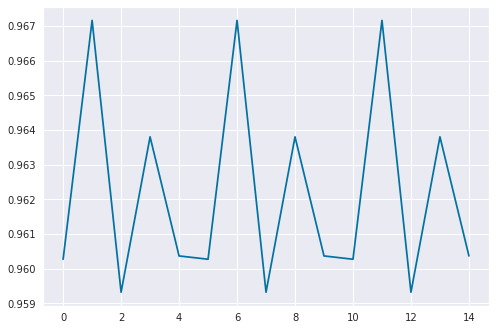

In [77]:
for train_index,test_index in skf.split(temp,target):
        xtrain,xtest = temp[temp.index.isin(train_index)],temp[temp.index.isin(test_index)]
        ytrain,ytest = target[train_index],target[test_index]
        
        model  = LogisticRegression(class_weight=class_weights,random_state=42)

        model.fit(xtrain,ytrain)
            
        preds = model.predict(xtest)
        
        print(f1_score(ytest,preds))
        scores.append(f1_score(ytest,preds))
        #
#
#        
print('-----------KFOLD--------------')
print(sns.lineplot(x=[i for i in range(len(scores))],y=scores))
print(min(scores),max(scores),np.mean(scores))

## Make Predictions on validation Data

In [69]:
final_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,Question,Label,Label_enc
0,-1.280513,-0.479057,-0.074593,-1.078833,0.555027,-0.304827,0.710984,0.278825,0.129274,0.484494,0.194379,0.099252,0.048627,0.641369,0.453775,-0.550658,-0.685677,0.614255,-0.001949,-0.382198,-0.034111,0.072872,0.070514,-0.182452,-0.672063,-0.203226,0.207312,-0.494412,-0.015926,0.394312,0.036818,0.289581,0.572028,0.346302,-0.048940,0.285914,0.699641,0.078200,-0.658135,-0.720307,...,0.345353,-0.443688,0.326153,0.006781,-0.017736,0.361109,0.084457,-0.220593,-0.326400,0.109498,-0.313511,0.126476,-1.023944,0.019120,0.276655,0.090974,-0.871337,0.066085,0.055102,0.710252,0.815904,0.116723,-0.763052,-0.191135,-0.117060,-0.917495,0.238745,-0.721925,-0.708831,0.919504,0.014720,-0.218466,-0.707999,-0.060461,-0.690394,0.655525,0.429932,manner How did serfdom develop in and then lea...,DESC,0
1,0.050765,-0.231588,0.449181,-0.434117,-0.437005,-0.025377,0.901859,0.299691,0.397571,0.363239,0.813872,-0.242552,-0.046876,0.664556,0.063659,-0.778084,-0.464536,0.818348,0.217839,-0.682176,-0.048324,0.305596,0.005277,-0.105053,-0.850086,-0.180318,0.599913,-0.693822,-0.018520,0.129673,0.459312,0.366443,-0.351863,0.442381,0.333915,-0.367255,1.370850,-0.371237,-0.394274,0.127977,...,0.269263,-0.234702,0.203369,0.363199,0.800868,0.343576,0.986706,-0.211597,0.346223,-0.544377,0.259784,-0.261309,-0.354508,-0.033133,0.439806,0.176840,-0.155799,-1.046834,-0.140347,0.822187,1.090696,-0.127105,-1.281975,0.121476,-0.035386,-1.036541,-0.455563,-1.028530,-0.167689,-0.617334,-0.128336,-0.154140,0.052781,0.287511,-0.945877,0.582182,0.169365,cremat What films featured the character Popey...,FACT,1
2,0.165783,0.086285,0.996058,-0.007494,-0.062556,-0.447119,1.157736,-0.594608,-0.278916,0.288759,-0.755688,0.518913,-0.589019,-0.218035,-0.299750,-0.588890,-1.044726,0.417887,-0.516429,-0.688118,0.293211,0.023602,-0.186256,0.847153,-0.451656,0.414896,0.153552,-0.524880,0.480987,0.345678,0.525045,0.589051,-0.483123,0.143385,0.049669,-0.625910,1.300623,-0.494312,0.039376,-0.539756,...,-0.603539,-0.569769,0.099041,0.707025,0.829515,-0.109335,0.677547,0.197822,0.223959,-0.297395,-0.826129,-0.965579,-0.218842,1.487624,-0.247484,-0.609410,-0.065343,-0.464756,-0.134924,1.308986,0.461914,-0.319942,-0.315665,-0.672880,0.423251,-1.299873,-0.380741,-1.354729,-0.239815,-0.171939,0.529478,-0.135893,1.097948,-0.018599,-1.401098,-0.166924,-0.666989,manner How can I find a list of celebrities ' ...,DESC,0
3,-0.178117,-0.473958,0.048357,-1.291486,-0.028839,0.348843,-0.046127,0.052366,-0.436607,1.082325,1.379477,0.269813,-0.224945,0.555075,0.196508,-1.012059,-0.139680,0.013313,0.595400,-0.556999,-0.128182,0.313684,-0.397969,0.625162,-1.139045,0.605109,0.438818,-0.294600,-0.015437,-0.200387,-0.028176,0.543886,-0.501193,0.160217,-0.207827,-0.185351,0.511596,-0.588324,0.523013,-0.696837,...,-0.185516,-0.183404,0.793519,0.255795,0.518475,0.655392,0.389528,-0.159402,0.155687,-0.318773,-0.182897,-0.584351,-1.437036,0.627801,0.532542,0.662939,0.678889,-0.622288,0.319153,0.996853,0.696457,0.012059,-0.387256,0.541324,0.047869,-0.789448,-0.599024,-0.941753,0.158490,-0.710274,0.030269,0.281970,0.180029,0.274251,-0.035899,1.007164,-0.209412,animal What fowl grabs the spotlight after the...,FACT,1
4,-0.341517,-0.614352,0.075421,-0.381870,-0.037142,-0.639595,1.047396,1.109776,-0.500967,-0.308551,-0.026306,0.817467,0.180813,0.402919,0.446856,-0.506134,-0.852798,0.875699,-0.568851,-0.948410,0.342488,-0.257153,-0.041044,1.054365,0.182189,0.183330,0.685496,-0.191475,-0.196328,-0.376523,0.161194,-0.232624,-0.124186,0.408084,0.532743,-0.697111,-0.076796,-0.269128,-0.596582,-0.246367,...,-0.507654,-0.372031,0.384393,-0.427786,-0.062957,0.381884,-0.210031,-0.373228,0.138790,-0.295719,-0.431427,-0.521124,0.406644,0.222613,-0.5398

## Doing the split again to asociate the questions and corresponding labels with the training and validation sample

In [78]:
X_train,X_val,Y_train,Y_val = train_test_split(final_train.drop('Label_enc',axis=1),final_train['Label_enc'],test_size=0.15,stratify=final_train['Label_enc'],random_state=42)

In [79]:
X_val_new = X_val.drop(['Question','Label'],axis=1)

In [80]:
y_pred = model.predict(X_val_new)

In [81]:
len(y_pred )

830

## F1 Score

In [82]:
f1_score(y_pred,Y_val)

0.9847560975609756

## Confusion Matrix

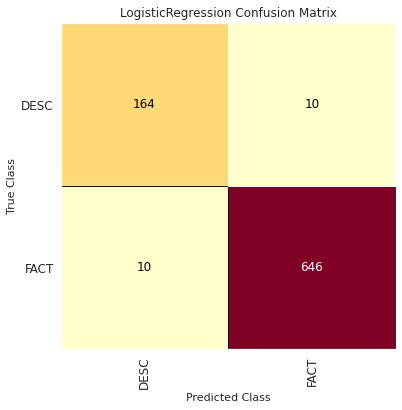

In [83]:
mapping = {0: "DESC", 1: "FACT"}
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
    model,
    classes=["DESC", "FACT"],
    label_encoder=mapping,
)
cm_viz.score(X_val_new , Y_val)
cm_viz.poof()

## ROC -AUC Plot

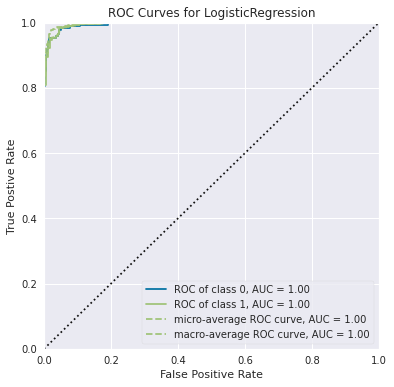

In [84]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(model)
roc_viz.score(X_val_new, Y_val)
roc_viz.poof()

## Retrieve Prediction Probabilities for Each Class

In [85]:
pred_proba = model.predict_proba(X_val_new)

In [86]:
pred_proba 

array([[9.96273796e-01, 3.72620425e-03],
       [3.21838690e-02, 9.67816131e-01],
       [8.87997857e-01, 1.12002143e-01],
       ...,
       [9.98325547e-01, 1.67445283e-03],
       [9.87246763e-01, 1.27532374e-02],
       [2.73480612e-04, 9.99726519e-01]])

## Store the prediction Probabilities into a DataFrame

In [87]:
df_pred = pd.DataFrame(pred_proba,columns=lb.classes_)

In [88]:
df_pred

,DESC,FACT
0,0.996274,0.003726
1,0.032184,0.967816
2,0.887998,0.112002
3,0.016470,0.983530
4,0.998142,0.001858
...,...,...
825,0.000005,0.999995
826,0.002246,0.997754
827,0.998326,0.001674
828,0.987247,0.012753


## Formatting the Validation Data

In [89]:
X_val[['Question','Label']]

,Question,Label
3461,def What is the meaning of the name Kathryn ?\n,DESC
1616,ind Who is stationed at Camp Swampy in the com...,FACT
5269,reason What made the short-lived Star Hawks st...,DESC
4342,event What was the worst hurricane ?\n,FACT
3798,def What is the meaning of `` CPR '' ?\n,DESC
...,...,...
261,exp CNN is the abbreviation for what ?\n,FACT
4106,date When did the American Civil War end ?\n,FACT
4889,desc What is the difference between hair and f...,DESC
4746,def What is the definition of cecum ?\n,DESC


In [90]:
predictions_made = X_val[['Question','Label']].copy()

In [91]:
predictions_made['Label_Predicted'] = y_pred

In [92]:
predictions_made.head()

,Question,Label,Label_Predicted
3461,def What is the meaning of the name Kathryn ?\n,DESC,0
1616,ind Who is stationed at Camp Swampy in the com...,FACT,1
5269,reason What made the short-lived Star Hawks st...,DESC,0
4342,event What was the worst hurricane ?\n,FACT,1
3798,def What is the meaning of `` CPR '' ?\n,DESC,0


In [93]:
predictions_made['Label_Predicted'].unique()

array([0, 1])

## Generate Label Mapper

In [94]:
names = lb.classes_.tolist()

In [95]:
mapper = {k:v for k,v in enumerate(lb.classes_.tolist())}
mapper 

{0: 'DESC', 1: 'FACT'}

In [96]:
predictions_made['Label_Predicted'] = predictions_made['Label_Predicted'].map(mapper)

In [97]:
predictions_made.reset_index(inplace=True)

In [98]:
predictions_made = predictions_made.drop('index',axis=1)
predictions_made.head()

,Question,Label,Label_Predicted
0,def What is the meaning of the name Kathryn ?\n,DESC,DESC
1,ind Who is stationed at Camp Swampy in the com...,FACT,FACT
2,reason What made the short-lived Star Hawks st...,DESC,DESC
3,event What was the worst hurricane ?\n,FACT,FACT
4,def What is the meaning of `` CPR '' ?\n,DESC,DESC


In [99]:
final_validation_preds = pd.concat((predictions_made,df_pred),axis=1)

In [100]:
final_validation_preds.head()

,Question,Label,Label_Predicted,DESC,FACT
0,def What is the meaning of the name Kathryn ?\n,DESC,DESC,0.996274,0.003726
1,ind Who is stationed at Camp Swampy in the com...,FACT,FACT,0.032184,0.967816
2,reason What made the short-lived Star Hawks st...,DESC,DESC,0.887998,0.112002
3,event What was the worst hurricane ?\n,FACT,FACT,0.016470,0.983530
4,def What is the meaning of `` CPR '' ?\n,DESC,DESC,0.998142,0.001858


## Misclassified Labels after prediction

In [101]:
final_validation_preds[(final_validation_preds['Label'] == 'DESC')&(final_validation_preds['Label'] != final_validation_preds['Label_Predicted'])]

,Question,Label,Label_Predicted,DESC,FACT
145,reason What caused Shea & Gould to close their...,DESC,FACT,0.219097,0.780903
165,manner How do they find an epicenter ?\n,DESC,FACT,0.452925,0.547075
233,manner How do you make panoramic sugar eggs fo...,DESC,FACT,0.286394,0.713606
268,manner How is Abigail Arcane related to the vi...,DESC,FACT,0.242980,0.757020
285,reason Why are the U.S. presidential elections...,DESC,FACT,0.032296,0.967704
295,desc What do a diamond and lump of coal have i...,DESC,FACT,0.134288,0.865712
426,def What is the filmmakers collabrative ?\n,DESC,FACT,0.480959,0.519041
516,manner How do you exterminate bees that are in...,DESC,FACT,0.326247,0.673753
765,reason Why was the L.A. office of Shea and Gou...,DESC,FACT,0.098569,0.901431
812,desc What were the three prophecies the witche...,DESC,FACT,0.244988,0.755012


##Make Predictions on unseen data sample - Prediction Pipeline

In [102]:
import pickle
import pandas as pd 
import numpy as np
from sentence_transformers import SentenceTransformer

## Save the LogisticRegression Model

In [103]:
import os
filename = "LogisticRegression.pkl"
folder  = "/content/drive/MyDrive/ZeonAI"
model_path = os.path.join(folder,filename)
pickle.dump(model, open(model_path, 'wb'))

## RandomForest Classifier

In [104]:
from sklearn.model_selection import GridSearchCV
grid_params = {'max_depth': [2,3,5,7,10],
               'n_estimators' :[200,250,300,350,500]}
estimator = RandomForestClassifier(class_weight={0:2.3451417,1:0.63549095},random_state=42)

In [105]:
gridcv = GridSearchCV(estimator=estimator, 
                      param_grid=grid_params,
                      scoring = 'f1',
                      verbose=10,
                      cv=5,
                       n_jobs=-1)


In [106]:
gridcv.fit(features,lbls)
print(gridcv.best_params_)
print(gridcv.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 19.5min finished


{'max_depth': 10, 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 2.3451417, 1: 0.63549095},
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


0.9081139172487909
0.9068389876144319
0.9219088937093275
0.9194159004867495
0.9203734211971445
-----------KFOLD--------------
AxesSubplot(0.125,0.125;0.775x0.755)
0.9068389876144319 0.9671574178935448 0.9504706129080007


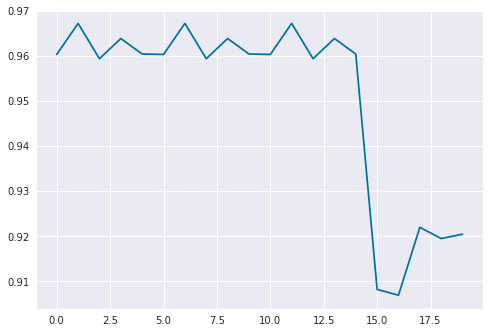

In [107]:
for train_index,test_index in skf.split(temp,target):
        xtrain,xtest = temp[temp.index.isin(train_index)],temp[temp.index.isin(test_index)]
        ytrain,ytest = target[train_index],target[test_index]
        
        model  = RandomForestClassifier( max_depth=10,
                                        n_estimators=300,
                                        class_weight={0:2.3451417,1:0.63549095},
                                        random_state=42)

        model.fit(xtrain,ytrain)
            
        preds = model.predict(xtest)
        
        print(f1_score(ytest,preds))
        scores.append(f1_score(ytest,preds))
        #
#
#        
print('-----------KFOLD--------------')
print(sns.lineplot(x=[i for i in range(len(scores))],y=scores))
print(min(scores),max(scores),np.mean(scores))

In [109]:
y_pred = model.predict(X_val_new)
print(f'accuracy_score :{accuracy_score(y_pred,Y_val)}')
print(f'F1_score :{f1_score(y_pred,Y_val)}')

accuracy_score :0.9662650602409638
F1_score :0.978819969742814


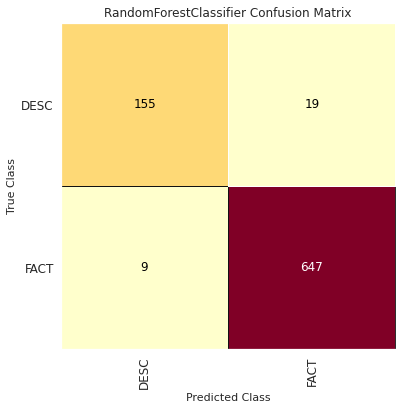

In [111]:
mapping = {0: "DESC", 1: "FACT"}
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
    model,
    classes=["DESC", "FACT"],
    label_encoder=mapping,
)
cm_viz.score(X_val_new, Y_val)
cm_viz.poof()

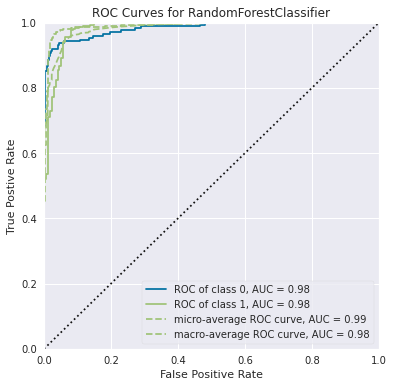

In [113]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(model)
roc_viz.score(X_val_new, Y_val)
roc_viz.poof()

* LogisticRegression scored better : 98.47%

* RandomForestClassifier scored : 97.88%

## Define The Prediction Pipeline

In [128]:
class process_test_data():
  def __init__(self,file_path,model_path,mapper):
    self.file_path = file_path
    self.model_path = model_path
    self.mapper = mapper
  def read_data(self):
    self.TEST = pd.read_excel(self.file_path)
    self.TEST = self.TEST.rename(columns={'Query':'Question'})
    print(self.TEST.shape)
  def generate_vectors(self):
    self.sentence_list = self.TEST.Question.values.tolist()
    model = SentenceTransformer('sentence-transformers/distilbert-base-nli-mean-tokens')
    embeddings = model.encode(self.sentence_list)
    print(len(embeddings))
    self.train_vector = pd.DataFrame(np.array(embeddings))
    print(self.train_vector.shape)
  def load_and_predict(self):
    loaded_model = pickle.load(open(self.model_path , 'rb'))
    predictions = loaded_model.predict(self.train_vector)
    pred_proba = loaded_model.predict_proba(self.train_vector)
    print(len(predictions))
    names = [ k for k in self.mapper.values()]
    self.proba = pd.DataFrame(pred_proba,columns=names)
    self.TEST['Predicted Labels'] = predictions
    self.TEST['Predicted Labels'] = self.TEST['Predicted Labels'].map(mapper)
    self.TEST = pd.concat([self.TEST,self.proba],axis=1)
    return self.TEST
 



## Process Test Data for labels

In [130]:
test_set = pd.read_excel("/content/drive/MyDrive/ZeonAI/TestSet_QueryClassification.xlsx")
test_set.head()

,S.No.,Query,Actual Label
0,1,Who is Genpact's CEO ?,HUM
1,2,What was the diluted earnings per share for Ge...,NUM
2,3,What was the final verdict in Pralipsa Rout vs...,DESC
3,4,What is the court’s’ notice number that allows...,NUM
4,5,What are the components in the monthly gross s...,DESC/ENTY


## Process Labels 

In [131]:
test_set['Label'] = test_set['Actual Label'].map(map_labels)
test_set.head()

,S.No.,Query,Actual Label,Label
0,1,Who is Genpact's CEO ?,HUM,FACT
1,2,What was the diluted earnings per share for Ge...,NUM,FACT
2,3,What was the final verdict in Pralipsa Rout vs...,DESC,DESC
3,4,What is the court’s’ notice number that allows...,NUM,FACT
4,5,What are the components in the monthly gross s...,DESC/ENTY,FACT


In [132]:
test_set.to_excel("/content/drive/MyDrive/ZeonAI/processed_test_data.xlsx",index=False)

## Instantiate Class and retrive the final predictions

In [134]:
[ k for k in mapper.values()]

['DESC', 'FACT']

In [135]:
file_path = "/content/drive/MyDrive/ZeonAI/processed_test_data.xlsx"
model_path = "/content/drive/MyDrive/ZeonAI/LogisticRegression.pkl"
mapper = {0: 'DESC', 1: 'FACT'}
testdata = process_test_data(file_path,model_path,mapper)
testdata.read_data()
testdata.generate_vectors()
df= testdata.load_and_predict()

(20, 4)
20
(20, 768)
20


## Analyze the predictions made on test data

In [136]:
df.head()

,S.No.,Question,Actual Label,Label,Predicted Labels,DESC,FACT
0,1,Who is Genpact's CEO ?,HUM,FACT,FACT,0.001239,0.998761
1,2,What was the diluted earnings per share for Ge...,NUM,FACT,FACT,0.000030,0.999970
2,3,What was the final verdict in Pralipsa Rout vs...,DESC,DESC,FACT,0.453213,0.546787
3,4,What is the court’s’ notice number that allows...,NUM,FACT,FACT,0.003684,0.996316
4,5,What are the components in the monthly gross s...,DESC/ENTY,FACT,FACT,0.002068,0.997932


## Missclassifications 5 out of 20 based on old test data

In [137]:
df[df['Label'] != df['Predicted Labels']]

,S.No.,Question,Actual Label,Label,Predicted Labels,DESC,FACT
2,3,What was the final verdict in Pralipsa Rout vs...,DESC,DESC,FACT,0.453213,0.546787
5,6,How can one establish residency in California ...,DESC,DESC,FACT,0.227392,0.772608
14,15,How is the Premium Calculated?,DESC,DESC,FACT,0.120080,0.879920
16,17,Why are Afro-Americans so good in athetics?,DESC,DESC,FACT,0.007285,0.992715
18,19,What was the final decision in disposing of th...,DESC,DESC,FACT,0.495357,0.504643
